# Collobrative Filtering

In [19]:
import pandas as pd
import os
from scipy.sparse import csr_matrix

# Data Wrangling

In [20]:
data_path = 'data-files/'
movies_filename = data_path + 'movies.csv'
ratings_filename = data_path + 'ratings.csv'

In [25]:
df_movies = pd.read_csv(
    movies_filename,
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [26]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [27]:
df_ratings.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [29]:
print(df_movies.shape)

(27278, 2)


In [31]:
df_ratings = df_ratings[:2000000]
print(df_ratings.shape)

(2000000, 3)


In [32]:
df_movie_features = df_ratings.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)

In [34]:
mat_movie_features = csr_matrix(df_movie_features.values)
df_movie_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,13558,13559,13560,13561,13562,13563,13564,13565,13566,13567
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,5.0,0.0,4.0,0.0,4.0,...,3.0,4.0,0.0,2.0,4.0,0.0,5.0,4.5,0.0,0.0
2,3.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
3,0.0,4.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0,0.0,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# KNN ALgorithm

In [35]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [36]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 13567 unique users and 16715 unique movies in this data set


In [38]:
# Get count by rating
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,23427
1.0,68420
1.5,27518
2.0,146105
2.5,89328
3.0,432669
3.5,217863
4.0,557816
4.5,151291


In [39]:
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]

df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,224772405
0.5,23427
1.0,68420
1.5,27518
2.0,146105
2.5,89328
3.0,432669
3.5,217863
4.0,557816
4.5,151291


In [40]:
import numpy as np
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,224772405,19.230599
0.5,23427,10.061644
1.0,68420,11.133420
1.5,27518,10.222596
2.0,146105,11.892081
2.5,89328,11.400070
3.0,432669,12.977728
3.5,217863,12.291622
4.0,557816,13.231784
4.5,151291,11.926960


Text(0, 0.5, 'number of ratings')

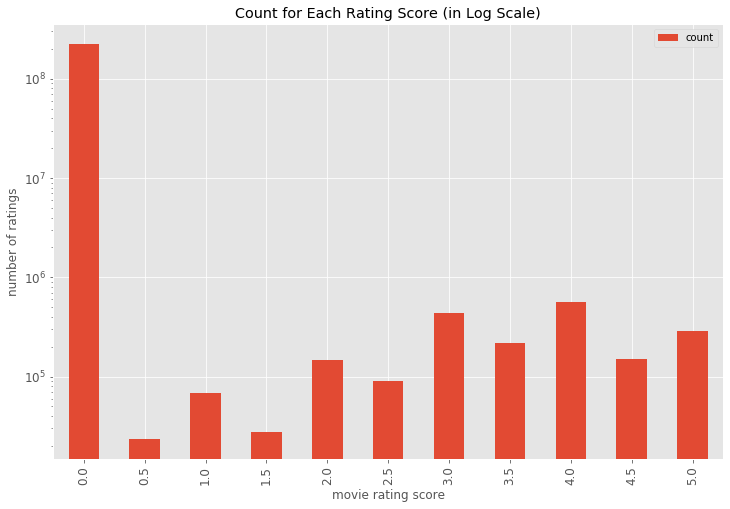

In [41]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [42]:
# get rating frequency
#number of ratings each movie got.
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,4883
2,2209
3,1256
4,272
5,1227


In [43]:
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (2000000, 3)
shape of ratings data after dropping unpopular movies:  (1876209, 3)


In [44]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,166
2,58
3,187
4,28
5,66


In [45]:
# filter data to come to an approximation of user likings.
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (2000000, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (1712154, 3)


In [46]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
#map movie titles to images
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

### Build the model

In [47]:
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [50]:
from fuzzywuzzy import fuzz

/opt/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [51]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. 
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

In [52]:
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [54]:
my_favorite = 'Toy Story'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Toy Story
Found possible matches in our database: ['Toy Story (1995)', 'Toy Story 3 (2010)', 'Toy Story 2 (1999)']

Recommendation system start to make inference
......

Recommendations for Toy Story:
1: Pulp Fiction (1994), with distance of 0.408139169216156
2: Star Wars: Episode V - The Empire Strikes Back (1980), with distance of 0.40672963857650757
3: Toy Story 2 (1999), with distance of 0.4046943187713623
4: Lion King, The (1994), with distance of 0.39655691385269165
5: Back to the Future (1985), with distance of 0.3928336501121521
6: Aladdin (1992), with distance of 0.38924604654312134
7: Star Wars: Episode VI - Return of the Jedi (1983), with distance of 0.38832491636276245
8: Jurassic Park (1993), with distance of 0.38393574953079224
9: Star Wars: Episode IV - A New Hope (1977), with distance of 0.37609797716140747
10: Forrest Gump (1994), with distance of 0.3728138208389282
